# **BLACK SCHOLES MODEL**

**IMPORTS AND SETUP**

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad

**DEFINE PINN MODEL**

In [2]:
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x)


**DEFINE PDE LOSS FUNCTION**

In [3]:
def bs_pde_loss(model, S, t, sigma=0.2, r=0.05):
    x = torch.stack([S, t], dim=1).requires_grad_(True)
    V = model(x)

    grads = grad(V, x, torch.ones_like(V), create_graph=True)[0]
    dV_dS = grads[:, 0]
    dV_dt = grads[:, 1]

    d2V_dS2 = grad(dV_dS, x, torch.ones_like(dV_dS), create_graph=True)[0][:, 0]

    pde = dV_dt + 0.5 * sigma**2 * S**2 * d2V_dS2 + r * S * dV_dS - r * V
    return torch.mean(pde**2)

**TERMINAL LOSS**

In [4]:
def terminal_loss(model, S, K=100):
    t1 = torch.ones_like(S)
    x = torch.stack([S, t1], dim=1)
    V_pred = model(x).squeeze()
    V_true = torch.maximum(S - K, torch.tensor(0.0))
    return torch.mean((V_pred - V_true)**2)


**MODEL TRAINING**

In [5]:
def train(model, epochs=10000, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        S = torch.rand(1000) * 200  # asset price [0, 200]
        t = torch.rand(1000)        # time [0, 1]
        loss_pde = bs_pde_loss(model, S, t)

        S_terminal = torch.linspace(0, 200, 1000)
        loss_terminal = terminal_loss(model, S_terminal)

        loss = loss_pde + loss_terminal
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 200 == 0:
            print(f"Epoch {epoch} | Total Loss: {loss.item():.6f}")


**VISUALIZATION**

In [6]:
def plot_surface(model):
    S_vals = np.linspace(1, 200, 100)
    t_vals = np.linspace(0, 1, 100)
    S_grid, t_grid = np.meshgrid(S_vals, t_vals)

    model.eval()
    S_tensor = torch.tensor(S_grid.flatten(), dtype=torch.float32)
    t_tensor = torch.tensor(t_grid.flatten(), dtype=torch.float32)
    x = torch.stack([S_tensor, t_tensor], dim=1)

    with torch.no_grad():
        preds = model(x).reshape(S_grid.shape).numpy()

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(S_grid, t_grid, preds, cmap='viridis')
    ax.set_xlabel("Stock Price")
    ax.set_ylabel("Time to Maturity")
    ax.set_zlabel("Option Price")
    ax.set_title("PINN-Predicted Option Price Surface")
    plt.show()


**RUN BLACK SCHOLES PIPELINE**

Epoch 0 | Total Loss: 1668.531494
Epoch 200 | Total Loss: 1040.866333
Epoch 400 | Total Loss: 631.021484
Epoch 600 | Total Loss: 394.406830
Epoch 800 | Total Loss: 252.939957
Epoch 1000 | Total Loss: 164.851028
Epoch 1200 | Total Loss: 109.505585
Epoch 1400 | Total Loss: 74.030174
Epoch 1600 | Total Loss: 50.997574
Epoch 1800 | Total Loss: 36.147324
Epoch 2000 | Total Loss: 25.877449
Epoch 2200 | Total Loss: 18.814360
Epoch 2400 | Total Loss: 14.423308
Epoch 2600 | Total Loss: 11.369693
Epoch 2800 | Total Loss: 8.669355
Epoch 3000 | Total Loss: 7.024936
Epoch 3200 | Total Loss: 6.035705
Epoch 3400 | Total Loss: 5.611562
Epoch 3600 | Total Loss: 5.063291
Epoch 3800 | Total Loss: 4.286920
Epoch 4000 | Total Loss: 3.925750
Epoch 4200 | Total Loss: 3.396230
Epoch 4400 | Total Loss: 3.419313
Epoch 4600 | Total Loss: 3.474858
Epoch 4800 | Total Loss: 3.028895
Epoch 5000 | Total Loss: 3.029901
Epoch 5200 | Total Loss: 2.923709
Epoch 5400 | Total Loss: 2.926675
Epoch 5600 | Total Loss: 2.90396

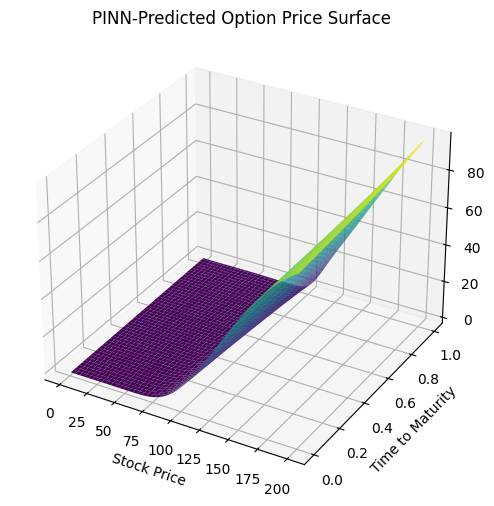

In [7]:
bs_model = PINN()
train(bs_model)
plot_surface(bs_model)

**MODEL SAVING**

In [8]:
torch.save(bs_model.state_dict(), "black_scholes_model.pth")